# Импорт необходимых пакетов

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn packages
import sklearn.metrics as mtrx # меры качества
from sklearn.preprocessing import MinMaxScaler # масштабирование
from sklearn.model_selection import GridSearchCV # Поиск по решетке
from sklearn.model_selection import cross_val_score # оценка кросс-валидации
from sklearn.model_selection import cross_validate # кросс-валидация
from sklearn.model_selection import train_test_split # разделение на обучающую/тестовую выборки

from sklearn.svm import SVR # метод регрессии опорных векторов
from sklearn.naive_bayes import GaussianNB # наивный Байес

from scipy.cluster.hierarchy import dendrogram # дендрограмма
from sklearn.cluster import AgglomerativeClustering # агломеративная кластеризация
from sklearn.cluster import KMeans # к-средних

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Задача регрессии

Смоделируем тестовую задачу регрессии.

$ y = sin(x) + N(0, 0.25), x \in [-5,9] $

In [ ]:
# sample volume
volume = 50
minX = -3
maxX = 9

x = np.random.uniform(minX, maxX, volume)
y = np.sin(x)
yNoisy = y + np.random.normal(0, 0.25, volume)

# сохраним в датафрейм как зашумеленные, так и исходные данные
data = pd.DataFrame({'x':x, 'y': yNoisy, 'yClean': y})
data.head()

,x,y,yClean
0,-2.199768,-0.631181,-0.808633
1,-1.533840,-0.903947,-0.999317
2,-0.316694,-0.740420,-0.311427
3,3.648972,0.067457,-0.485888
4,-1.223774,-0.303174,-0.940389


Построим график по выборке

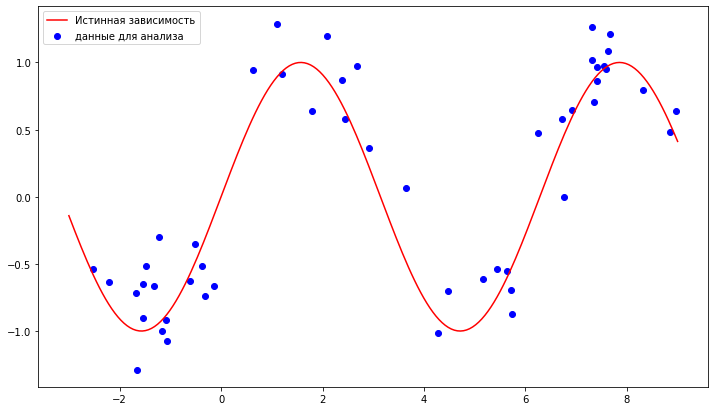

In [ ]:
xSin = np.linspace(minX, maxX, 200)
ySin = np.sin(xSin)

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(xSin, ySin, color='red', label='Истинная зависимость')
ax.scatter(data['x'], data['y'], color='blue', label='данные для анализа')
ax.legend()
plt.show()

Проверим диапазоны

In [ ]:
data[['x','y']].describe()

,x,y
count,50.000000,50.000000
mean,3.138624,0.067914
std,3.754129,0.809937
min,-2.518882,-1.286467
25%,-0.585881,-0.659402
50%,2.791724,0.031937
75%,6.876013,0.867210
max,8.959987,1.289513


В многомерных данных, масштабы значенй переменных могут существенно отличаться - необходимо привести к единому.

Для многих методов необходимо чтобы данные были в конкретном диапазоне (например, $[0,1]$).

In [ ]:
# мастабировние в [0,1]
scaler1 = MinMaxScaler()
tmp = scaler1.fit_transform(data[['x', 'y']])

dataScaled = pd.DataFrame(tmp, columns=['x','y'])
dataScaled.head()

,x,y
0,0.027800,0.254383
1,0.085813,0.148495
2,0.191847,0.211976
3,0.537322,0.525596
4,0.112825,0.381716


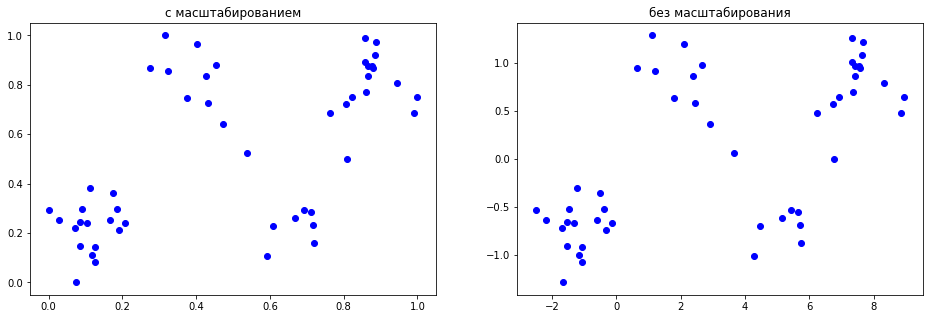

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax[0].scatter(dataScaled['x'],dataScaled['y'],
           color='blue')
ax[0].set_title("с масштабированием")
ax[1].scatter(data['x'],data['y'],
           color='blue')
ax[1].set_title("без масштабирования")
plt.show()

Для валидации разделим данные на обучающую и тестовую выборки

In [ ]:
# split into train and test
# trainX, testX, trainY, testY = train_test_split(X, Y)
train, test = train_test_split(dataScaled)
print("фрагмент обучающей выборки")
print(train.head(3))
print("")
print("фрагмент тестовой выборки")
print(test.head(3))

фрагмент обучающей выборки
           x         y
32  0.186191  0.297862
49  0.117822  0.110427
3   0.537322  0.525596

фрагмент тестовой выборки
           x         y
45  0.805335  0.723604
39  0.472639  0.640708
27  0.072669  0.221817


Построим модель методом регрессии опорных векторов

In [ ]:
# train SVR model with some parameters
svrModel = SVR(C=1.0, epsilon=0.2)
svrModel.fit(train['x'].values.reshape(-1,1),
             train['y'].values.reshape(-1,1))
predictSVR = svrModel.predict(test['x'].values.reshape(-1,1))

Построим кривую по полученной модели

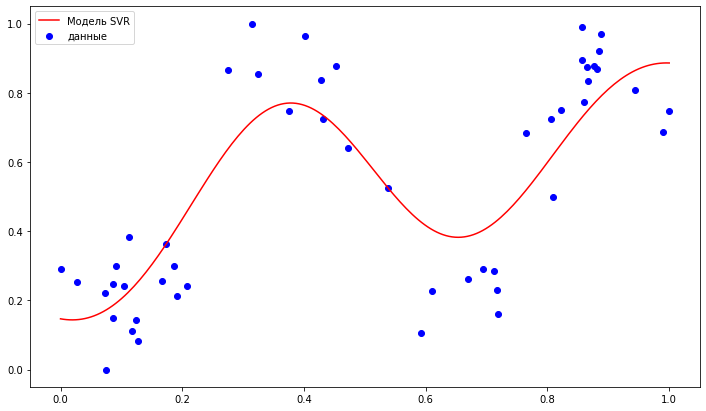

In [ ]:
# draw SVR model curve
xSVR = np.linspace(0, 1, 200)
ySVR = svrModel.predict(xSVR.reshape(-1,1))

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(xSVR,ySVR,color='red',
        label='Модель SVR')
ax.scatter(dataScaled['x'],dataScaled['y'],
           color='blue', label='данные')
ax.legend()
plt.show()

Вычислим некоторые меры качества

In [ ]:
# some regresion metrics
print('MSE:', mtrx.mean_squared_error(predictSVR, test['y']))
print('MSE (root):',
      mtrx.mean_squared_error(predictSVR, test['y'],
                              squared=False))
print('MAE:', mtrx.mean_absolute_error(predictSVR, test['y']))
print('R2:', mtrx.r2_score(predictSVR, test['y']))

MSE: 0.017869648404134655
MSE (root): 0.1336774042392156
MAE: 0.11066110242680932
R2: 0.7205740932758283


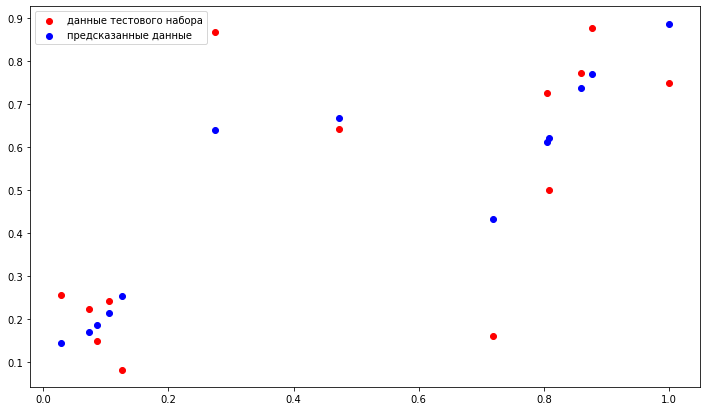

In [ ]:
# plot test data and prediction
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(test['x'],test['y'],
           color='red', label='данные тестового набора')
ax.scatter(test['x'],predictSVR,
           color='blue', label='предсказанные данные')
ax.legend()
plt.show()

Чтобы минимизиовать влияние неуданого случаного разбиения на обучение/тест, проведем 5-кратную кросс-валидацию

In [ ]:
# evaluate SVR using 5-fold crossvalidation
svrModel2 = SVR(C=1.0, epsilon=0.2)
scores = cross_validate(svrModel2,
                  dataScaled['x'].values.reshape(-1,1),
                  dataScaled['y'].values.reshape(-1,1),
                  scoring=('r2', 'neg_mean_squared_error'))

In [ ]:
scores

{'fit_time': array([0.00345063, 0.00105548, 0.00099015, 0.00126171, 0.00082564]),
 'score_time': array([0.00124145, 0.00102401, 0.00108194, 0.00098729, 0.00101423]),
 'test_r2': array([0.77969538, 0.6293781 , 0.78540537, 0.57880541, 0.80307285]),
 'test_neg_mean_squared_error': array([-0.0235603 , -0.0339323 , -0.02285199, -0.02555664, -0.01872588])}

In [ ]:
print('CV MSE:',
      np.mean(-1*scores['test_neg_mean_squared_error']))
print('CV R2:',
      np.mean(scores['test_r2']))

CV MSE: 0.02492542556010601
CV R2: 0.7152714216989242


На эффективность решения влияет выбор гиперпараметров модели. Можно попробовать подобрать параметры путем поиска "по решетке" и проверкой каждого набора через кросс-валидацию.

In [ ]:
# grid search for SVR parameters using CV
svrModel3=SVR()
parameters = {'C': [0.1, 0.5, 1., 1.5],
              'epsilon': [0.1, 0.25, 0.5, 0.75, 1]}
clf = GridSearchCV(svrModel3, parameters,
                   scoring=('neg_mean_squared_error'))
clf.fit(dataScaled['x'].values.reshape(-1,1),
                  dataScaled['y'].values.reshape(-1,1))

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 0.5, 1.0, 1.5],
                         'epsilon': [0.1, 0.25, 0.5, 0.75, 1]},
             scoring='neg_mean_squared_error')

In [ ]:
print('best parameters:', clf.best_params_)
print('best score:', -1*clf.best_score_)

best parameters: {'C': 1.5, 'epsilon': 0.1}
best score: 0.01693418652568245


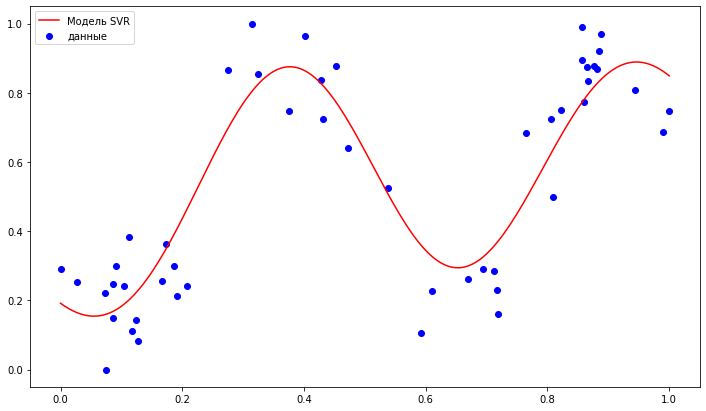

In [ ]:
# plot best model
xSVR = np.linspace(0, 1, 200)
ySVR = clf.best_estimator_.predict(xSVR.reshape(-1,1))

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(xSVR,ySVR,color='red', label='Модель SVR')
ax.scatter(dataScaled['x'],dataScaled['y'], color='blue', label='данные')
ax.legend()
plt.show()

Вернем данные, полученные по модели к исходному масштабу

In [ ]:
# reverse scaling
input = (data['x']- scaler1.data_min_[0]) / scaler1.data_range_[0]
prediction = clf.best_estimator_.predict(input.values.reshape(-1,1))
output = prediction * scaler1.data_range_[1] + scaler1.data_min_[1]
data['SVR'] = output
data.head(3)

,x,y,yClean,SVR
0,-2.199768,-0.631181,-0.808633,-0.864390
1,-1.533840,-0.903947,-0.999317,-0.854882
2,-0.316694,-0.740420,-0.311427,-0.234521


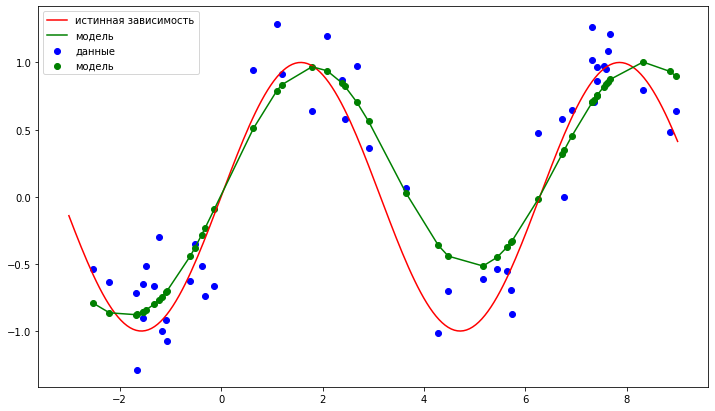

In [ ]:
# final plots
xSin=np.linspace(minX, maxX, 200)
ySin=np.sin(xSin)

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(xSin,ySin,color='red', label='истинная зависимость')
ax.scatter(data['x'],data['y'], color='blue', label='данные')
ax.scatter(data['x'],data['SVR'], color='green', label='модель')
ax.plot(np.sort(data['x']),data['SVR'][np.argsort(data['x'])], color='green', label='модель')
ax.legend()
plt.show()

# Задача классификация

Сгенерируем тетовую задачу классификации с помощью разделяющей поверхности.

$ y =\frac{x}{4} sin(3 \cdot x) + 0.9 \cdot x  $

In [ ]:
volume = 50
xMin = 0
xMax = 5
attr1 = np.random.uniform(xMin, xMax, volume)
attr2 = np.random.uniform(xMin, xMax, volume)
classLabel = np.where((attr1/4*np.sin(3.*attr1)+0.9*attr1-attr2)<0,
                      0, 1)

In [ ]:
data2 = pd.DataFrame({'attr1':attr1, 'attr2':attr2,
                      'label': classLabel})
data2.head()

,attr1,attr2,label
0,3.895889,2.134080,1
1,0.868175,1.967826,0
2,1.715274,3.808487,0
3,0.529327,3.091475,0
4,0.167163,1.484926,0


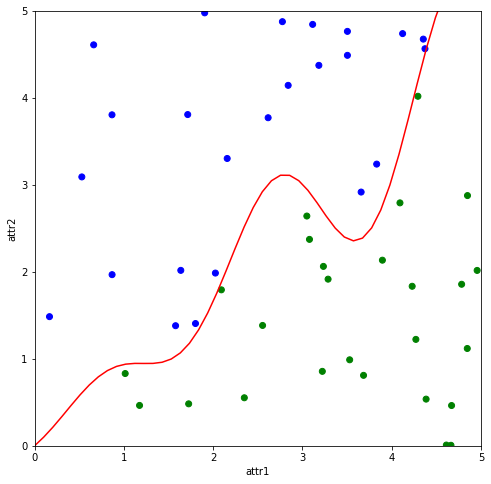

In [ ]:
x = np.linspace(0,5)
y = x/4*np.sin(3.*x)+0.9*x

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x,y,color='red')
ax.scatter(attr1, attr2, c=np.where(classLabel,'green','blue'))
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xlabel('attr1')
ax.set_ylabel('attr2')
plt.show()

In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   attr1   50 non-null     float64 
 1   attr2   50 non-null     float64 
 2   label   50 non-null     category
dtypes: category(1), float64(2)
memory usage: 1.1 KB


Метки классов определены как целый тип, нужно поменять на категориальный.

In [ ]:
# convert labels from numbers into category
data2['label'] = data2['label'].astype('category')
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   attr1   50 non-null     float64 
 1   attr2   50 non-null     float64 
 2   label   50 non-null     category
dtypes: category(1), float64(2)
memory usage: 1.1 KB


In [ ]:
data2['label'].describe()

count     50
unique     2
top        1
freq      26
Name: label, dtype: int64

In [ ]:
data2['label'].value_counts()

1    26
0    24
Name: label, dtype: int64

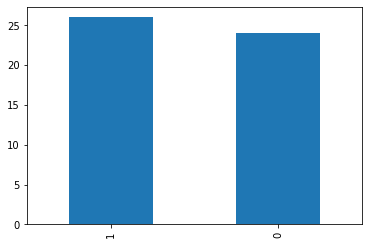

In [ ]:
data2['label'].value_counts().plot(kind='bar')

In [ ]:
train, test = train_test_split(data2)

Применим алгоритм Наивный Байесовский классификатор (вариант с гауссовыми функциями)

In [ ]:
gnb1 = GaussianNB()
gnb1.fit(train[['attr1','attr2']].values,
         train['label'].values)
predLabels = gnb1.predict(test[['attr1','attr2']])

Посчитаем меры качества, матрицу ошибок и напечатаем полный отчет.

In [ ]:
print('accuracy:',
      mtrx.accuracy_score(predLabels,test['label'])*100)
print('error:', (
    1-mtrx.accuracy_score(predLabels,test['label']))*100)
print('f1:',
      mtrx.f1_score(predLabels,test['label']))

accuracy: 92.3076923076923
error: 7.692307692307687
f1: 0.923076923076923


In [ ]:
mtrx.confusion_matrix(predLabels,test['label'])

array([[6, 0],
       [1, 6]])

In [ ]:
print(mtrx.classification_report(predLabels,test['label']))

Нарисуем прогноз на тестовой выборке.

In [ ]:
test['prediction']=predLabels

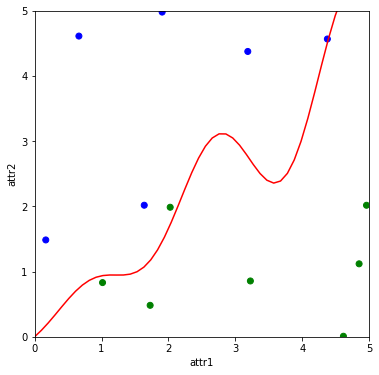

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x,y,color='red')
ax.scatter(test['attr1'], test['attr2'],
           c=np.where(test['prediction'],'green','blue'))
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_xlabel('attr1')
ax.set_ylabel('attr2')
plt.show()

*Примечаение. Для классификации также надо делать кросс-валидацию. Если алгоритм имеет параметры - подбирать.*

# Задача кластеризации

Сгенерируем 3 нормально распределенных и непересекающиеся группы данных.

In [ ]:
# [0,10]
x1=np.random.normal(3,0.7,20)
y1=np.random.normal(2,0.5,20)
label1=np.array([1]*20)
x2=np.random.normal(7,0.7,20)
y2=np.random.normal(4,0.5,20)
label2=np.array([2]*20)
x3=np.random.normal(4,1,20)
y3=np.random.normal(7,0.7,20)
label3=np.array([3]*20)

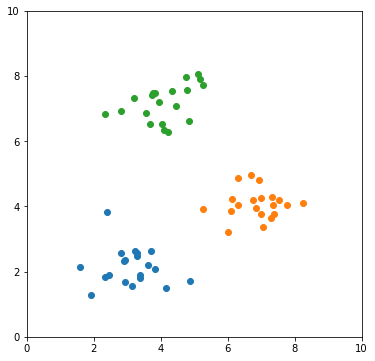

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x1, y1)
ax.scatter(x2, y2)
ax.scatter(x3, y3)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
plt.show()

Сохраним в датафрейм. Метки групп мы используем только для проверки для себя, алгоритм про них не будет знать.

In [ ]:
x=np.concatenate((x1,x2,x3))
y=np.concatenate((y1,y2,y3))
label=np.concatenate((label1,label2,label3))
data3=pd.DataFrame({'x':x,'y':y, 'label':label})
data3.head()

,x,y,label
0,3.633614,2.207576,1
1,2.934931,2.343134,1
2,2.402088,3.828624,1
3,2.938499,1.692828,1
4,3.377160,1.903747,1


Построим дендрограмму (пример взят с сайта matplotlib),

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

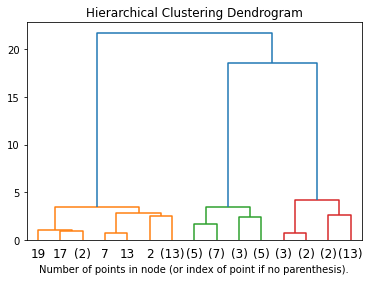

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(data3[['x','y']])

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Решим задачу методом К-средних с инициализацией начальных положений кластеров k-means++.

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(data3[['x','y']])

KMeans(n_clusters=3)

In [ ]:
kmeans.cluster_centers_

array([[4.09649707, 7.18168657],
       [6.86460263, 4.07522731],
       [3.10968752, 2.14808936]])

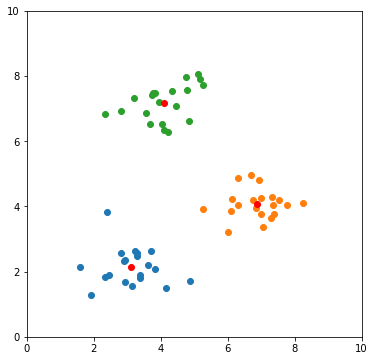

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x1, y1)
ax.scatter(x2, y2)
ax.scatter(x3, y3)
ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], color='red')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
plt.show()

In [ ]:
# прогноз меток кластеров
#Могут не совпадать с исходными. Важно чтобы в одной группе были одинаковые метки, какие именно - не важно, можно переназвать.
kmeans.labels_

array([1, 1, 9, 4, 1, 4, 1, 5, 1, 1, 1, 1, 1, 5, 4, 1, 1, 4, 4, 4, 0, 3,
       8, 8, 3, 0, 8, 0, 3, 8, 0, 0, 0, 8, 0, 0, 3, 0, 0, 3, 2, 2, 7, 2,
       2, 6, 2, 2, 2, 7, 2, 2, 6, 7, 2, 2, 7, 6, 2, 7], dtype=int32)

In [ ]:
# итоговое значение "инерции"
kmeans.inertia_

13.666237639941423

Проверим выбор числа кластов методом "локтя"

In [ ]:
inertia = []

for i in range(10):
  kmeans = KMeans(n_clusters=i+1, init='k-means++')
  kmeans.fit(data3[['x','y']])
  inertia.append(kmeans.inertia_)

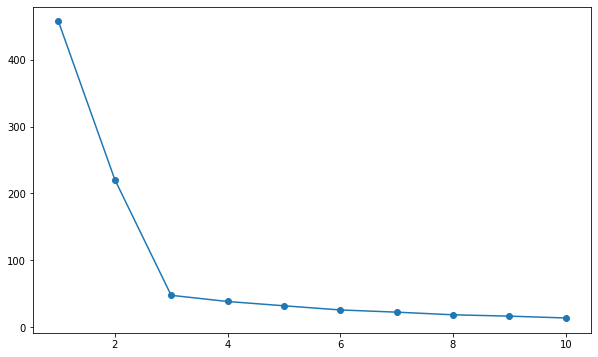

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(1,11), inertia)
ax.scatter(np.arange(1,11), inertia)
plt.show()